In [1]:
import sys
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import pandas as pd

from glob import glob
from PIL import Image


import tensorflow as tf
#print("TensorFlow version:", tf.__version__)
#print("GPU devices:", tf.config.list_physical_devices('GPU'))

from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#print(tf.sysconfig.get_build_info())

from tensorflow import keras

from tensorflow.keras import layers, Model

2025-12-04 21:50:52.220959: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 21:50:53.089932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 21:50:54.764373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Cycles Gan Generator

This notebook outline my work for creating a simple GAN model that can transform Digimon characters into a more Pokemon style. This is essentially "Bonus work" from my other notebook outlining a CNN model that can distinguish between the two.

Most of this code is heavily based on a tutorial notebook by Amy Jang: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial for this kaggle competition: https://www.kaggle.com/competitions/gan-getting-started.

I only build a GAN model to turn digimon characters into Pokemon characters and ignored the other image groups. More information on the data can be found on the "MonsterIdnetifier" notebook. 

In [2]:
import tensorflow as tf
import os

IMAGE_SIZE = [128, 128]
BATCH_SIZE = 1
AUTOTUNE = tf.data.AUTOTUNE

BASE_PATHS = ["Prepared/train", "Prepared/test", "Prepared/val"]
CLASSES = ["Pokémon", "Digimon"]

rotation_layer = tf.keras.layers.RandomRotation(
    factor=0.14,
    fill_mode='reflect'
)

# Preprocessing function
def load_and_preprocess(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMAGE_SIZE)

    # Augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.expand_dims(image, 0)
    image = rotation_layer(image)
    image = tf.squeeze(image, 0)

    image = tf.image.random_brightness(image, max_delta=0.001)
    image = tf.image.random_contrast(image, 0.999, 1.001)
    image = tf.image.random_saturation(image, 0.999, 1.001)

    # Noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
    image = image + noise

    # Normalize to [-1,1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0

    return image

# Create dataset for a single folder
def make_dataset_for_folder(folder, shuffle=True):
    files = tf.data.Dataset.list_files(os.path.join(folder, "*"), shuffle=shuffle)
    dataset = files.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Combine all base paths for a class
def make_class_dataset(base_paths, class_name):
    datasets = []
    for base in base_paths:
        folder = os.path.join(base, class_name)
        if os.path.exists(folder):
            datasets.append(make_dataset_for_folder(folder))
    if datasets:
        return datasets[0].concatenate(*datasets[1:])  # merge all datasets
    else:
        return None
    
def make_class_dataset(base_paths, class_name):
    datasets = []
    for base in base_paths:
        folder = os.path.join(base, class_name)
        if os.path.exists(folder):
            datasets.append(make_dataset_for_folder(folder))
    if datasets:
        combined = datasets[0]
        for ds in datasets[1:]:
            combined = combined.concatenate(ds)
        return combined
    else:
        return None


# Create Pokémon and Digimon datasets
pokemon_ds = make_class_dataset(BASE_PATHS, "Pokémon")
digimon_ds = make_class_dataset(BASE_PATHS, "Digimon")

print("Pokemon batches:", len(list(pokemon_ds)))
print("Digimon batches:", len(list(digimon_ds)))


I0000 00:00:1764903056.392422   50193 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5590 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-12-04 21:50:57.979205: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Pokemon batches: 819
Digimon batches: 1454


2025-12-04 21:50:58.689027: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00016117096..1.0005815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01136443..1.0003295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00011700392..1.0003426].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.051951885..1.0004073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00017392635..1.0004228].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010249019..1.000358].


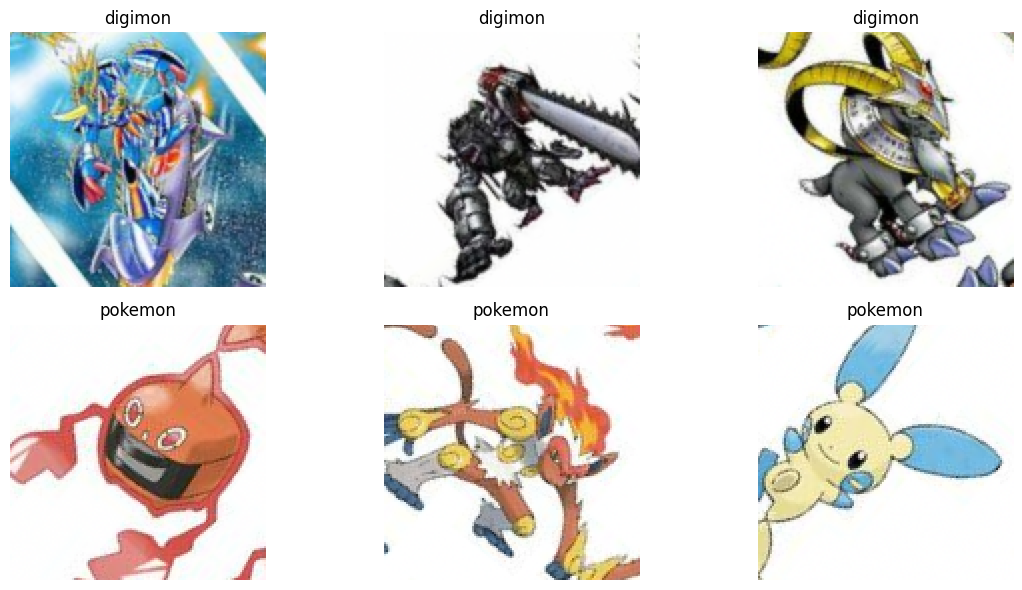

In [3]:
num_examples = 3

pokemon_iter = pokemon_ds.unbatch().take(num_examples)
digimon_iter = digimon_ds.unbatch().take(num_examples)

plt.figure(figsize=(12, 6))

for i, (digimon, pokemon) in enumerate(zip(digimon_iter, pokemon_iter)):
    # digimon
    plt.subplot(2, num_examples, i + 1)
    plt.title("digimon")
    plt.imshow(digimon * 0.5 + 0.5)
    plt.axis("off")

    # pokemon
    plt.subplot(2, num_examples, i + 1 + num_examples)
    plt.title("pokemon")
    plt.imshow(pokemon * 0.5 + 0.5)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=(input_shape[-1],), initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(input_shape[-1],), initializer='zeros', trainable=True)

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        return self.gamma * (x - mean) / tf.sqrt(var + self.epsilon) + self.beta

In [5]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization())

    result.add(layers.LeakyReLU(0.2))

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(InstanceNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU(0.2))

    return result

def residual_block(x):
    initializer = tf.random_normal_initializer(0., 0.02)

    filters = x.shape[-1]
    y = layers.Conv2D(filters, 3, padding='same', use_bias=False, kernel_initializer=initializer)(x)
    y = InstanceNormalization()(y)
    y = layers.ReLU()(y)
    
    y = layers.Conv2D(filters, 3, padding='same', use_bias=False, kernel_initializer=initializer)(y)
    y = InstanceNormalization()(y)
    
    return layers.Add()([x, y])

In [6]:
def Generator():
    inputs = layers.Input(shape=[128,128,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), 
    ]

    up_stack = [
        upsample(512, 4),
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2,padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    for _ in range(4):  # 2 residual blocks
        x = residual_block(x)

    skips = skips[:-1]   # remove last
    skips = skips[::-1]  # reverse order

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [7]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[128, 128, 3], name='input_image')

    x = inp

    down0 = downsample(64, 4, apply_instancenorm=False)(x)
    down1 = downsample(128, 4, apply_instancenorm=False)(down0)
    down2 = downsample(256, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(512, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm_layer = InstanceNormalization()
    norm1 = norm_layer(conv)

    leaky_relu = layers.LeakyReLU(0.2)(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [8]:
pokemon_generator = Generator() # digimons to pokemon-esque
digimon_generator = Generator() # pokemon to digimons

pokemon_discriminator = Discriminator() # differentiates real pokemon paintings and generated pokemon paintings
digimon_discriminator = Discriminator() # differentiates real digimons and generated digimons

2025-12-04 21:51:05.222369: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node random_rotation_1/AssignVariableOp/_9}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-12-04 21:51:05.222407: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node random_rotation_1/Add/_6}}]]
	 [[random_rotation_1/AssignVariableOp/_9]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-12-04 21:51:05.222411: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6050117866264000819
2025-12-04 21:51:05.222429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6050117866264000819
2025-12-04 21:51:05.222837: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is ca

input shape: (1, 128, 128, 3)
min/max: -1.0004121 1.0008838


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00020605326..1.0004419].


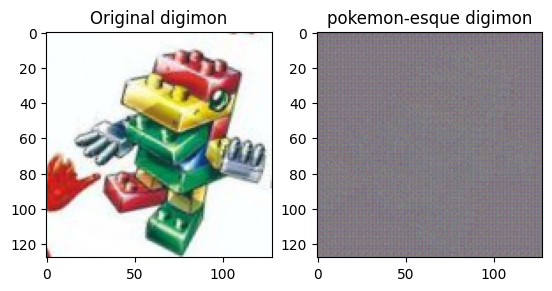

In [9]:
example_digimon = next(iter(digimon_ds.unbatch().take(1)))
example_digimon_batched = tf.expand_dims(example_digimon, axis=0)

print("input shape:", example_digimon_batched.shape)
print("min/max:", tf.reduce_min(example_digimon_batched).numpy(), tf.reduce_max(example_digimon_batched).numpy())

to_pokemon = pokemon_generator(example_digimon_batched, training=False)

plt.subplot(1, 2, 1)
plt.title("Original digimon")
plt.imshow(example_digimon * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("pokemon-esque digimon")
plt.imshow(to_pokemon[0] * 0.5 + 0.5)
plt.show()

In [10]:
class CycleGan(keras.Model):
    def __init__(
        self,
        pokemon_generator,
        digimon_generator,
        pokemon_discriminator,
        digimon_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = pokemon_generator
        self.p_gen = digimon_generator
        self.m_disc = pokemon_discriminator
        self.p_disc = digimon_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_pokemon, real_digimon = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # digimon to pokemon back to digimon
            fake_pokemon = self.m_gen(real_digimon, training=True)
            cycled_digimon = self.p_gen(fake_pokemon, training=True)

            # pokemon to digimon back to pokemon
            fake_digimon = self.p_gen(real_pokemon, training=True)
            cycled_pokemon = self.m_gen(fake_digimon, training=True)

            # generating itself
            same_pokemon = self.m_gen(real_pokemon, training=True)
            same_digimon = self.p_gen(real_digimon, training=True)

            # discriminator used to check, inputing real images
            disc_real_pokemon = self.m_disc(real_pokemon, training=True)
            disc_real_digimon = self.p_disc(real_digimon, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_pokemon = self.m_disc(fake_pokemon, training=True)
            disc_fake_digimon = self.p_disc(fake_digimon, training=True)

            # evaluates generator loss
            pokemon_gen_loss = self.gen_loss_fn(disc_fake_pokemon)
            digimon_gen_loss = self.gen_loss_fn(disc_fake_digimon)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_pokemon, cycled_pokemon, self.lambda_cycle) + self.cycle_loss_fn(real_digimon, cycled_digimon, self.lambda_cycle)

            # evaluates total generator loss
            total_pokemon_gen_loss = pokemon_gen_loss + total_cycle_loss + self.identity_loss_fn(real_pokemon, same_pokemon, self.lambda_cycle)
            total_digimon_gen_loss = digimon_gen_loss + total_cycle_loss + self.identity_loss_fn(real_digimon, same_digimon, self.lambda_cycle)

            # evaluates discriminator loss
            pokemon_disc_loss = self.disc_loss_fn(disc_real_pokemon, disc_fake_pokemon)
            digimon_disc_loss = self.disc_loss_fn(disc_real_digimon, disc_fake_digimon)

        # Calculate the gradients for generator and discriminator
        pokemon_generator_gradients = tape.gradient(total_pokemon_gen_loss,
                                                  self.m_gen.trainable_variables)
        digimon_generator_gradients = tape.gradient(total_digimon_gen_loss,
                                                  self.p_gen.trainable_variables)

        pokemon_discriminator_gradients = tape.gradient(pokemon_disc_loss,
                                                      self.m_disc.trainable_variables)
        digimon_discriminator_gradients = tape.gradient(digimon_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(pokemon_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(digimon_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(pokemon_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(digimon_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "pokemon_gen_loss": total_pokemon_gen_loss,
            "digimon_gen_loss": total_digimon_gen_loss,
            "pokemon_disc_loss": pokemon_disc_loss,
            "digimon_disc_loss": digimon_disc_loss
        }

In [11]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = bce(tf.ones_like(real), real)
    fake_loss = bce(tf.zeros_like(generated), generated)
    return (real_loss + fake_loss) * 0.5


def generator_loss(generated):
    return bce(tf.ones_like(generated), generated)

In [12]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [13]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
gen_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-4, decay_steps=10000, decay_rate=0.99, staircase=True
)

disc_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-4, decay_steps=10000, decay_rate=0.99, staircase=True
)

In [15]:
pokemon_generator_optimizer = tf.keras.optimizers.Adam(gen_lr_schedule, beta_1=0.5)
digimon_generator_optimizer = tf.keras.optimizers.Adam(gen_lr_schedule, beta_1=0.5)

pokemon_discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr_schedule, beta_1=0.5)
digimon_discriminator_optimizer = tf.keras.optimizers.Adam(disc_lr_schedule, beta_1=0.5)

In [16]:
cycle_gan_model = CycleGan(
    pokemon_generator, digimon_generator, pokemon_discriminator, digimon_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = pokemon_generator_optimizer,
    p_gen_optimizer = digimon_generator_optimizer,
    m_disc_optimizer = pokemon_discriminator_optimizer,
    p_disc_optimizer = digimon_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
    )

In [31]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((pokemon_ds, digimon_ds)),
    epochs=60
)

Epoch 1/60
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 108ms/step - digimon_disc_loss: 0.5461 - digimon_gen_loss: 2.0040 - pokemon_disc_loss: 0.4277 - pokemon_gen_loss: 2.0227
Epoch 2/60
819/819 ━━━━━━━━━━━━━━━━━━━━ 91s 111ms/step - digimon_disc_loss: 0.7460 - digimon_gen_loss: 1.7866 - pokemon_disc_loss: 1.1252 - pokemon_gen_loss: 1.5794
Epoch 3/60
819/819 ━━━━━━━━━━━━━━━━━━━━ 153s 107ms/step - digimon_disc_loss: 0.8627 - digimon_gen_loss: 1.8908 - pokemon_disc_loss: 0.9240 - pokemon_gen_loss: 1.5452
Epoch 4/60
819/819 ━━━━━━━━━━━━━━━━━━━━ 91s 111ms/step - digimon_disc_loss: 0.6056 - digimon_gen_loss: 2.0076 - pokemon_disc_loss: 0.6302 - pokemon_gen_loss: 1.6719
Epoch 5/60
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 107ms/step - digimon_disc_loss: 0.6825 - digimon_gen_loss: 2.4742 - pokemon_disc_loss: 0.7601 - pokemon_gen_loss: 1.4935
Epoch 6/60
819/819 ━━━━━━━━━━━━━━━━━━━━ 90s 110ms/step - digimon_disc_loss: 1.0273 - digimon_gen_loss: 1.9850 - pokemon_disc_loss: 1.0959 - pokemon_gen_loss: 1.8874
Epoch 7/6

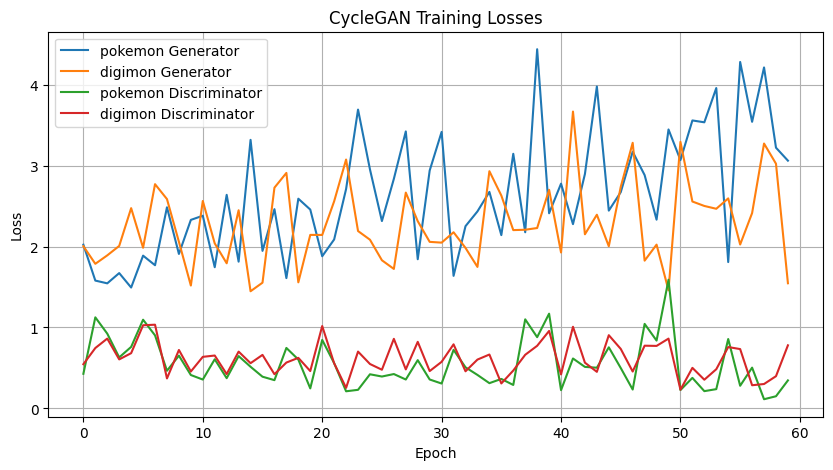

In [32]:
plt.figure(figsize=(10,5))

# Generator losses
plt.plot(history.history['pokemon_gen_loss'], label='pokemon Generator')
plt.plot(history.history['digimon_gen_loss'], label='digimon Generator')

# Discriminator losses
plt.plot(history.history['pokemon_disc_loss'], label='pokemon Discriminator')
plt.plot(history.history['digimon_disc_loss'], label='digimon Discriminator')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CycleGAN Training Losses")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
example_digimon = next(iter(digimon_ds.unbatch().take(1)))

# add batch dimension -> shape becomes [1, H, W, 3]
example_digimon_batched = tf.expand_dims(example_digimon, axis=0)

# optional: sanity checks
print("input shape:", example_digimon_batched.shape)
print("min/max:", tf.reduce_min(example_digimon_batched).numpy(), tf.reduce_max(example_digimon_batched).numpy())

to_pokemon = pokemon_generator(example_digimon_batched, training=False)

plt.subplot(1, 2, 1)
plt.title("Original digimon")
plt.imshow(example_digimon * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("pokemon-esque digimon")
plt.imshow(to_pokemon[0] * 0.5 + 0.5)
plt.show()

NameError: name 'digimon_ds' is not defined